In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8')

In [32]:
df = pd.read_csv('C:/Users/lenovo/Desktop/data.csv')
print(df.head())
print(df.info())

      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7388318 entries, 0 to 7388317
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 338.2 MB
None


In [33]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

In [34]:
original_len = len(df)

df = df.dropna(subset=['Open', 'High', 'Low', 'Close'])

df['High'] = np.maximum(df['High'], df['Low'])
df['Low'] = np.minimum(df['Low'], df['High'])
df['Close'] = np.clip(df['Close'], df['Low'], df['High'])

price_change = df['Close'].diff().abs()
constant_mask = (price_change < 1e-6) & (df['Volume'] == 0)
is_constant_error = constant_mask.rolling(window=10, min_periods=1).sum() >= 10

valid_mask = (
    (df['Close'] >= 10) & 
    (df['Close'] <= 100000) & 
    (~is_constant_error) & 
    (df['Volume'] >= 0)
)
df_clean = df[valid_mask].copy()

print(f"After cleaning: {len(df_clean)}  ({(1 - len(df_clean)/original_len)*100:.1f}% removed)")

After cleaning: 6575606  (11.0% removed)


Extreme jump point: 11700
Microstructure noise: 2430762


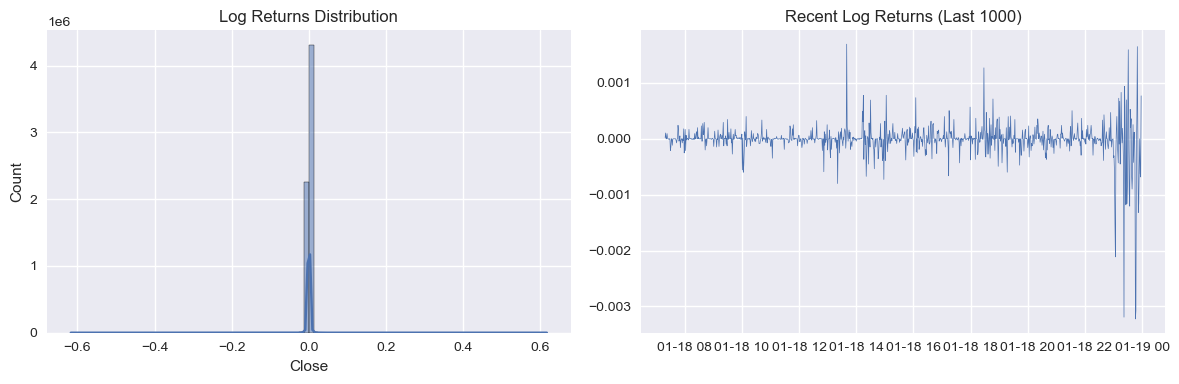

In [35]:
returns = np.log(df_clean['Close'] / df_clean['Close'].shift(1))

rolling_std = returns.rolling(window=60).std()
extreme_jump = abs(returns) > (5 * rolling_std)

bid_ask_bounce = (returns * returns.shift(1)) < 0

print(f"Extreme jump point: {extreme_jump.sum()}")
print(f"Microstructure noise: {bid_ask_bounce.sum()}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(returns.dropna(), bins=100, kde=True)
plt.title('Log Returns Distribution')

plt.subplot(1, 2, 2)
plt.plot(returns.index[-1000:], returns.values[-1000:], linewidth=0.5)
plt.title('Recent Log Returns (Last 1000)')
plt.tight_layout()
plt.show()

In [36]:
sampling_freq = '1T'


df_resampled = df_clean.resample(sampling_freq).last().dropna()
resampled_returns = np.log(df_resampled['Close'] / df_resampled['Close'].shift(1)).dropna()

rv_daily = resampled_returns.groupby(resampled_returns.index.date).apply(lambda x: np.sum(x**2))
rv_daily.index = pd.to_datetime(rv_daily.index) 

minutes_per_sample = int(sampling_freq[:-1]) if sampling_freq[:-1].isdigit() else 1
annualization_factor = 252 * (1440 // minutes_per_sample)  # 1440 = 24*60
rv_annualized = np.sqrt(rv_daily * annualization_factor)

print(f"Daily frequency RV observation count: {len(rv_daily)}")

Daily frequency RV observation count: 4713



 ADF stationarity test:
ADF Statistic: -9.6276
p-value: 0.00000000000000016442
Result: stable


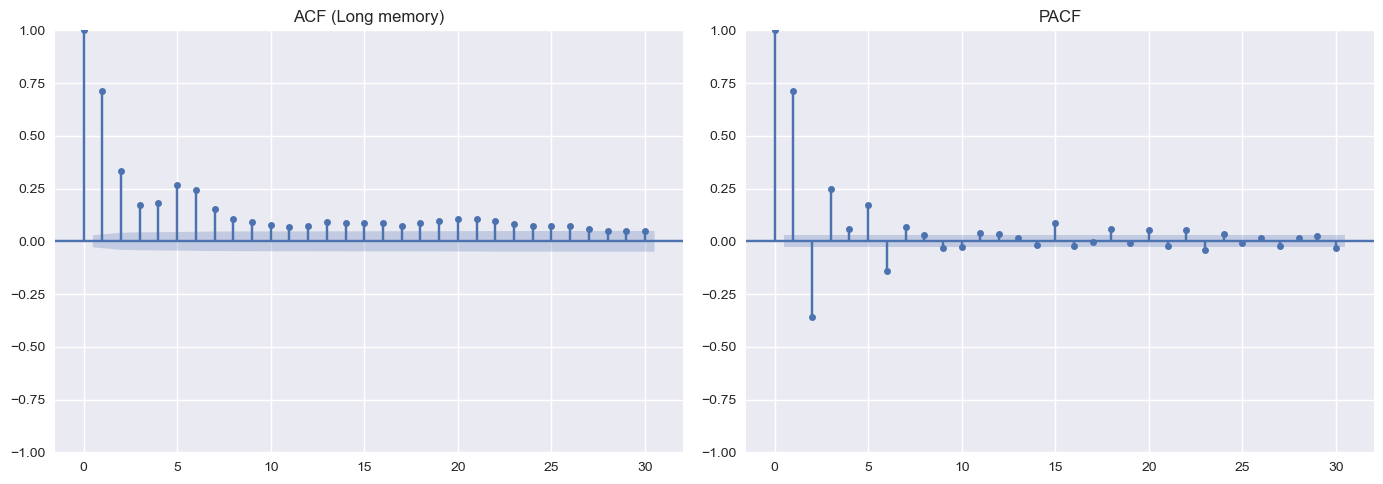

In [39]:
# ADF stationarity test
adf_result = adfuller(rv_daily.dropna())
print("\n ADF stationarity test:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.20f}")
print("Result: " + ("stable" if adf_result[1] < 0.05 else "unstable"))

# Autocorrelation plot (checking for long memory)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(rv_daily.dropna(), lags=30, ax=axes[0])
plot_pacf(rv_daily.dropna(), lags=30, ax=axes[1])
axes[0].set_title('ACF (Long memory)')
axes[1].set_title('PACF')
plt.tight_layout()
plt.show()

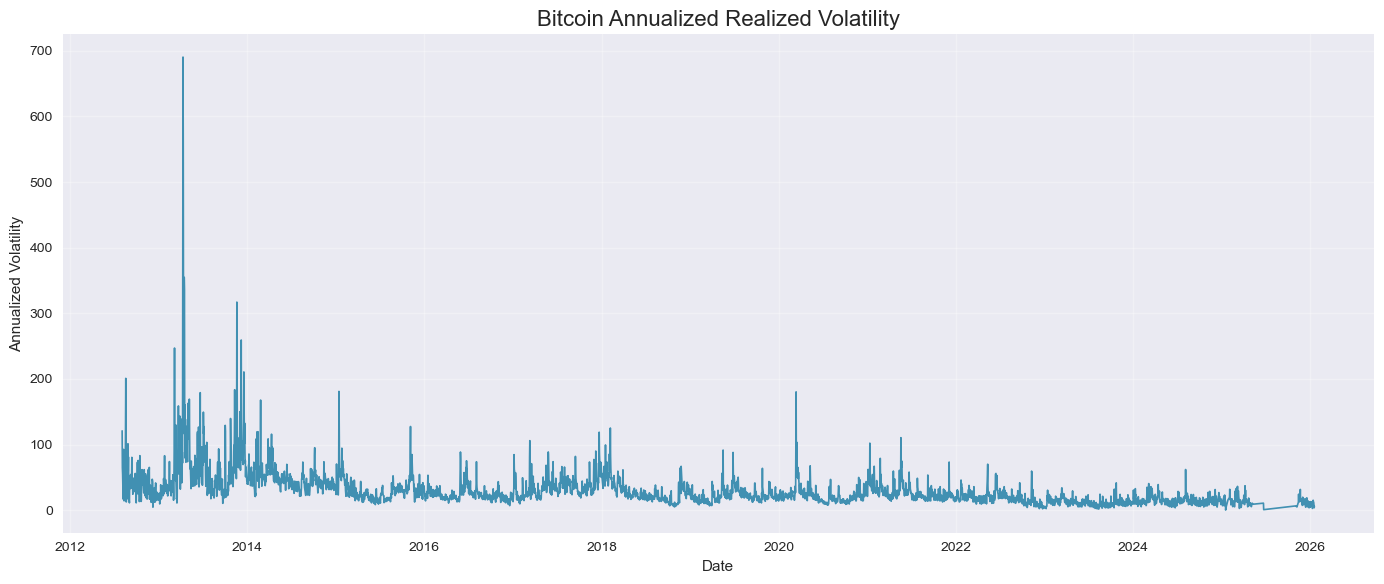

In [40]:
plt.figure(figsize=(14, 6))
plt.plot(rv_annualized, color='#2E86AB', linewidth=1.2, alpha=0.9)
plt.title('Bitcoin Annualized Realized Volatility', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [41]:
rv_daily.to_csv('cleaned_rv_daily.csv', header=['rv'])
rv_annualized.to_csv('cleaned_rv_annualized.csv', header=['rv_annualized'])

print("Result has been saved:")
print("- cleaned_rv_daily.csv")
print("- cleaned_rv_annualized.csv")

Result has been saved:
- cleaned_rv_daily.csv
- cleaned_rv_annualized.csv
